**Copied from [LangChain: Chat with Your Data](https://learn.deeplearning.ai/langchain-chat-with-your-data)** Use the short course to learn about RAG. This is only tested on M1.

## Retrieval augmented generation
 
In retrieval augmented generation (RAG), an LLM retrieves contextual documents from an external dataset as part of its execution. 

This is useful if we want to ask question about specific documents (e.g., our PDFs, a set of videos, etc). 


This notebook uses [langchain](https://python.langchain.com/) and was changed to run offline
* Uses [llama.cpp](https://github.com/ggerganov/llama.cpp) as inference engine by running a local openAI API compatible server.
* HuggingFace local embedding

Redis is used as 

* Retrieving contextual data for RAG using [Redis as a Vector Database](https://python.langchain.com/docs/integrations/vectorstores/redis)
* [Semantic Cache](https://python.langchain.com/docs/integrations/llms/llm_caching#semantic-cache) for prompts based on semantic similarity between the prompt and previously cached results
* [Chat Memory History](https://python.langchain.com/docs/integrations/memory/redis_chat_message_history)



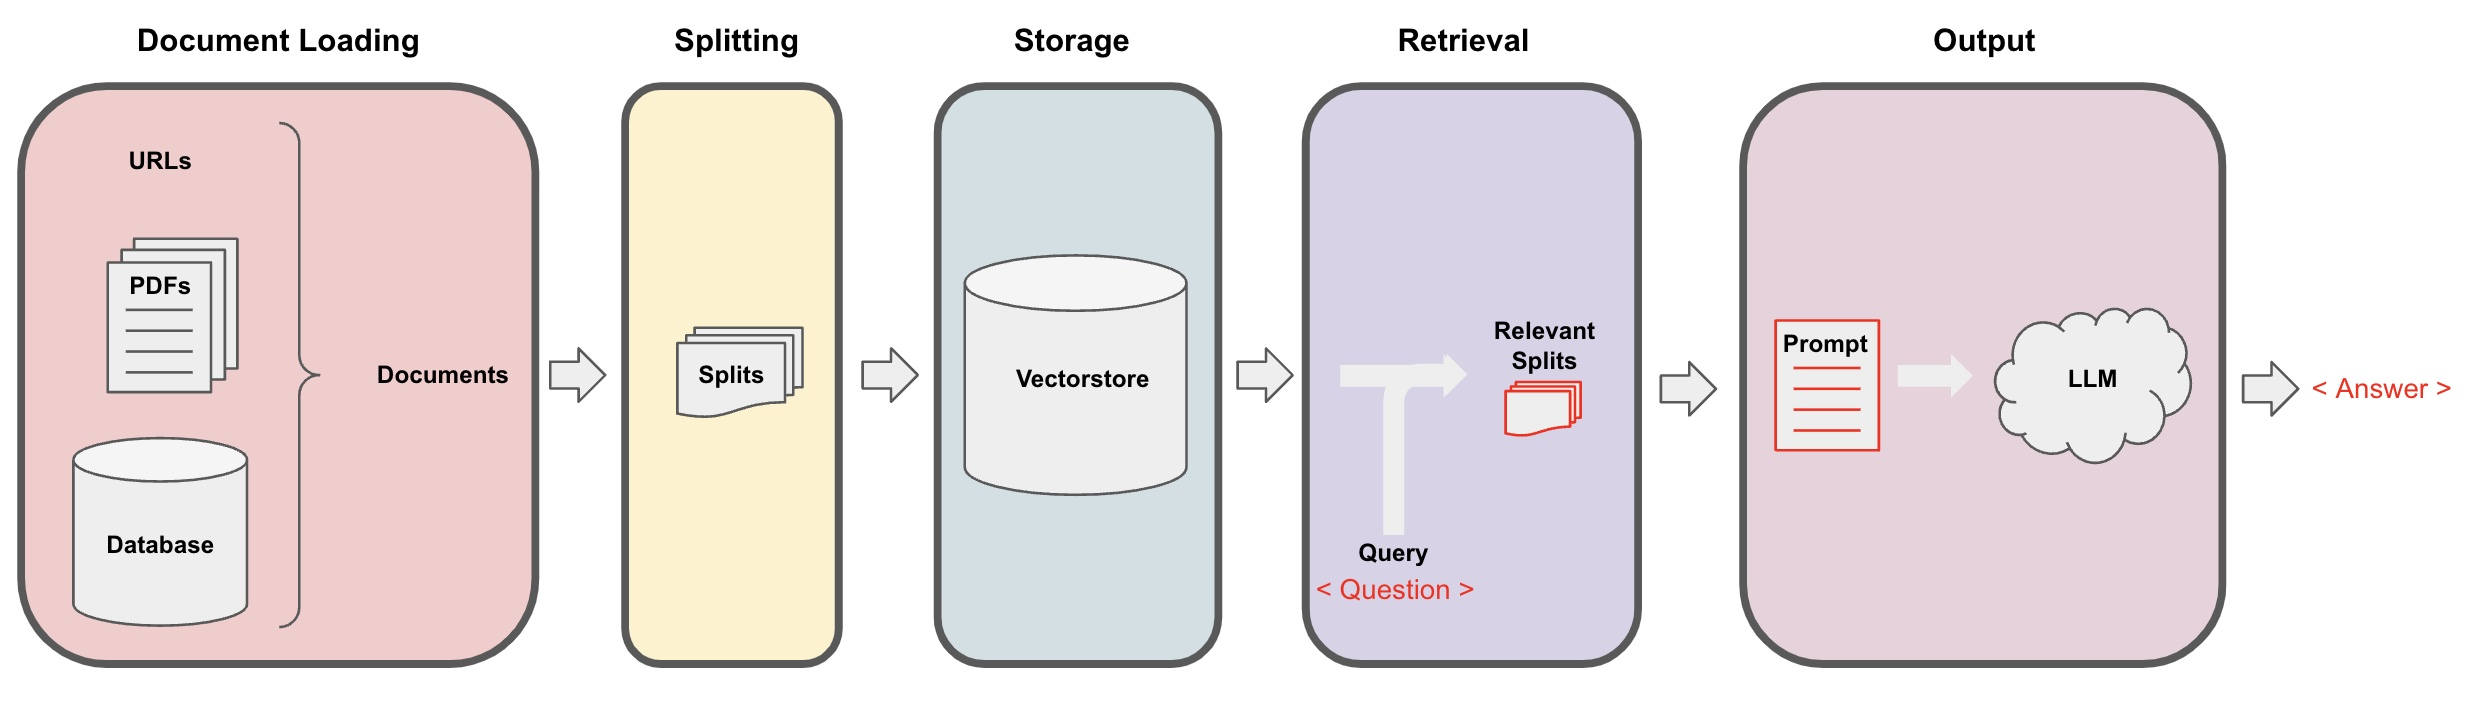

In [ ]:
! pip install langchain
! pip install openai

In [ ]:
import os
import openai
import sys

In [ ]:
! pip install pypdf 

# Document Loading

## PDF Document

Let's load a PDF document

In [ ]:
from langchain.document_loaders import PyPDFLoader
loaders = [
    PyPDFLoader("docs/Buyers Guide for Enterprise Caching (2022-02).pdf"),
    PyPDFLoader("docs/the-economist- corporate-espionage-is-entering-a-new-era.pdf"),
    PyPDFLoader("docs/How Silicon Valley is helping the Pentagon in the AI arms race _ Financial Times.pdf"),
    PyPDFLoader("docs/2022-chevrolet-colorado-ebrochure.pdf"),
    #PyPDFLoader("docs/kubernetes-docs.pdf"),
    #PyPDFLoader("docs/rc-docs.pdf"),
    #PyPDFLoader("docs/ri-docs.pdf"),
    PyPDFLoader("docs/rs-docs.pdf"),
    #PyPDFLoader("docs/stack-docs.pdf")
]
pages = []
for loader in loaders:
    pages.extend(loader.load())

Each page is a `Document`.

A `Document` contains text (`page_content`) and `metadata`.

In [ ]:
len(pages)

In [ ]:
page = pages[3]

In [ ]:
print(page.page_content[0:500])

## URLs

In [ ]:
#from langchain.document_loaders import WebBaseLoader

#loader = WebBaseLoader("https://github.com/basecamp/handbook/blob/master/37signals-is-you.md")

In [ ]:
#webdocs = loader.load()

In [ ]:
#print(webdocs[0].page_content[:500])

# Splitting Text

We will use `RecursiveCharacterTextSplitter` and also add lookback period as seperator

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=450,
    chunk_overlap=50,
    separators=["\n\n", "\n", "(?<=\. )", " ", ""],
)

In [ ]:
docs = r_splitter.split_documents(pages)

In [ ]:
len(pages)

In [ ]:
len(docs)

In [ ]:
docs[0]

# Storage

## Embeddings
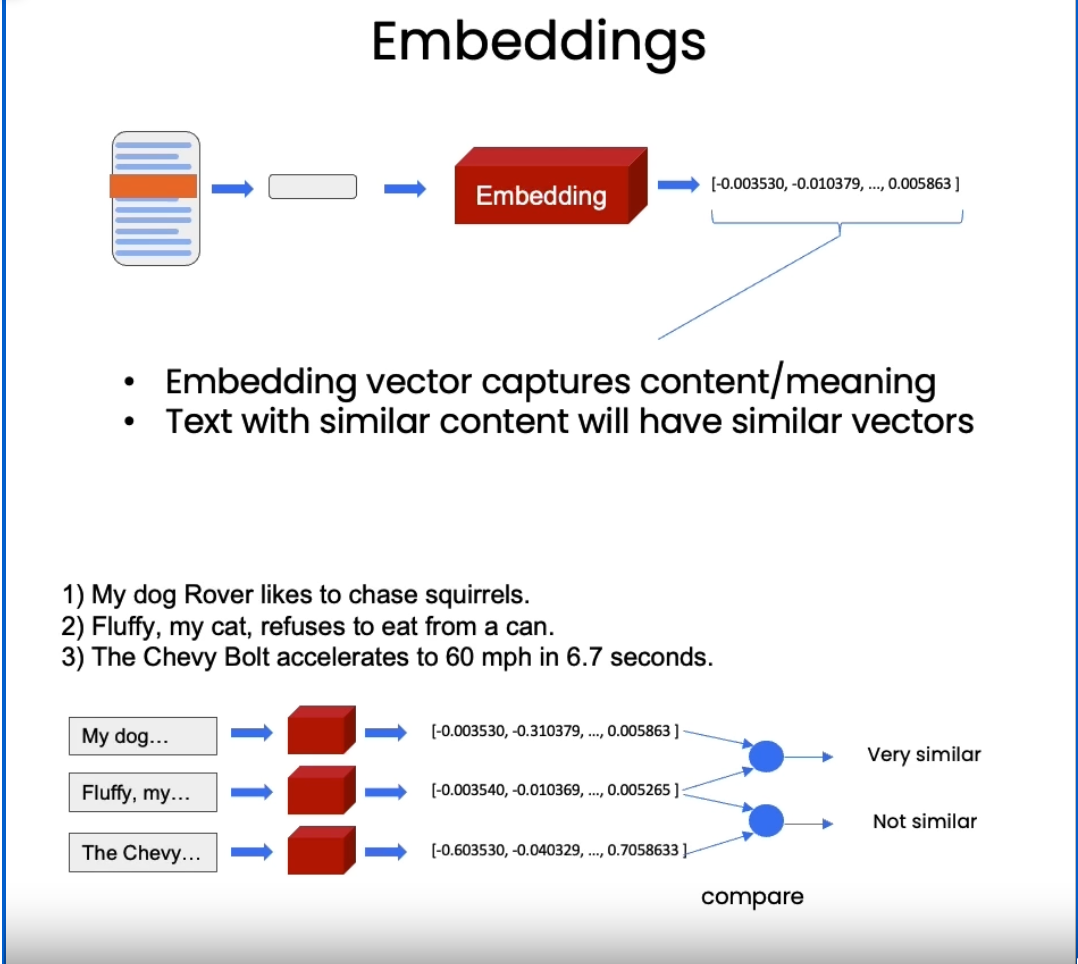

In [ ]:
! pip install sentence_transformers

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
embedding = HuggingFaceEmbeddings()

In [ ]:
sentence1 = "i like dogs"
sentence2 = "i like canines"
sentence3 = "the weather is ugly outside"

In [ ]:
embedding1 = embedding.embed_query(sentence1)
embedding2 = embedding.embed_query(sentence2)
embedding3 = embedding.embed_query(sentence3)

In [ ]:
import numpy as np

In [ ]:
len(embedding1)

In [ ]:
np.dot(embedding1, embedding2)

In [ ]:
np.dot(embedding1, embedding3)

In [ ]:
np.dot(embedding2, embedding3)

## Vectorstores
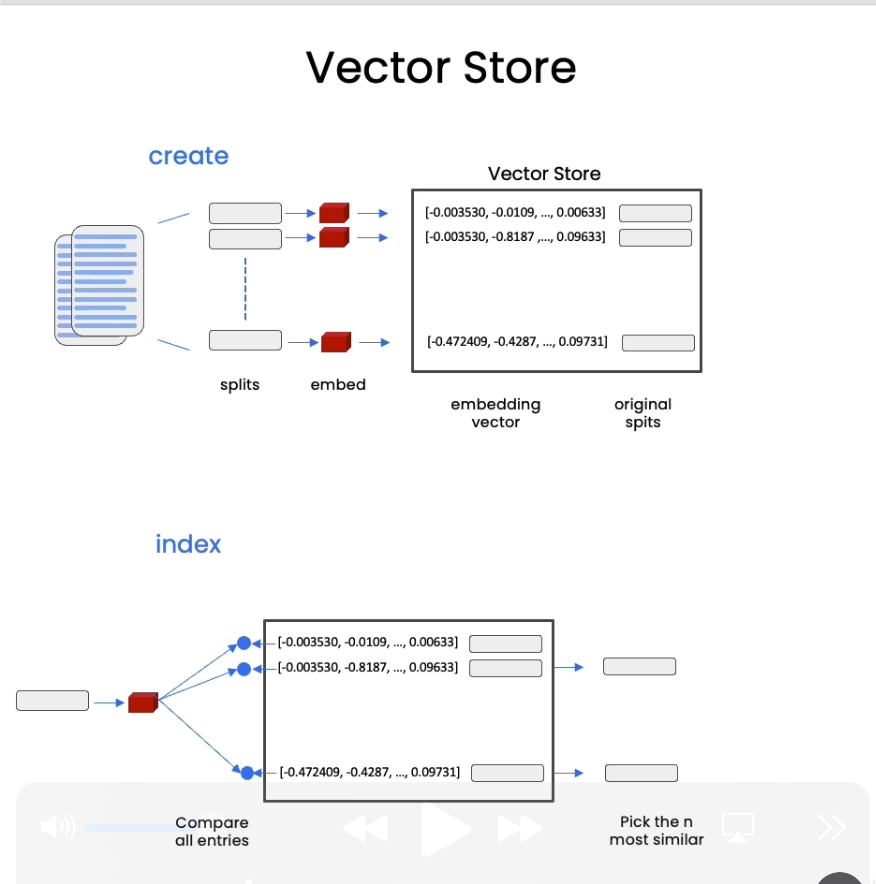
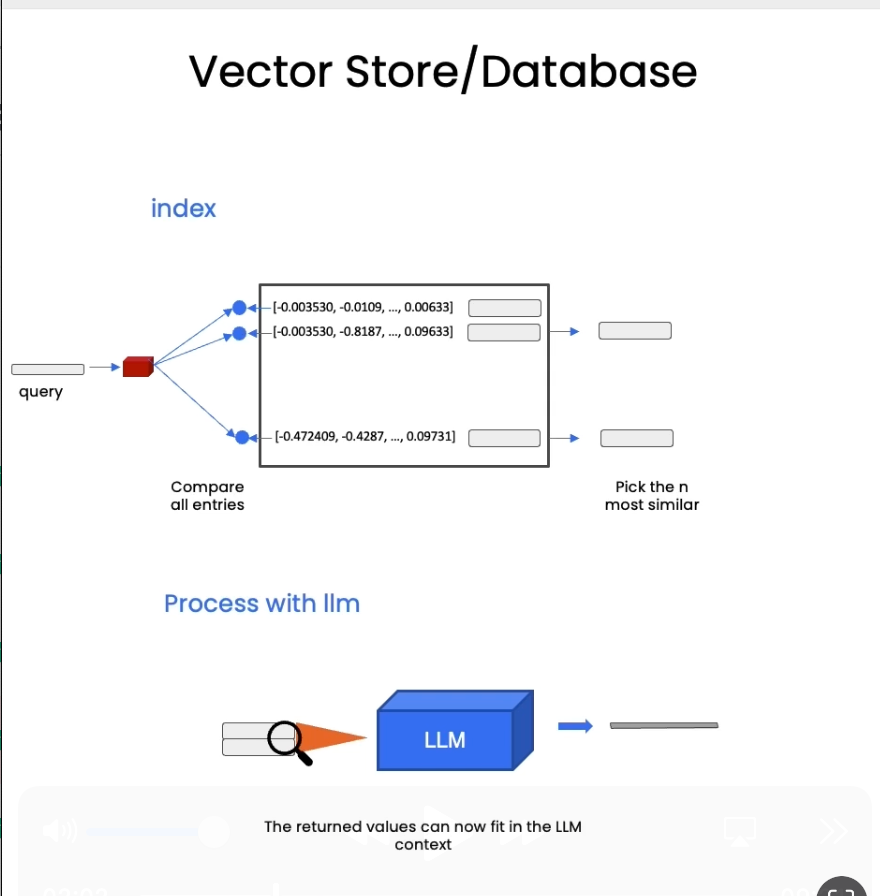

In [ ]:
 ! pip install redis

In [ ]:
redis_url = "redis://localhost:6379"
index_name = "docs"

In [ ]:
from langchain.vectorstores.redis import Redis as RedisVectorStore

In [ ]:
vectordb = RedisVectorStore.from_documents(documents=docs,
                                embedding=embedding,
                                index_name=index_name,
                                redis_url=redis_url)

# Retrieval

## Similarity Search

In [ ]:
question = "What is a good cache"

In [ ]:
docs = vectordb.similarity_search(question,k=3)

In [ ]:
#vectordb.max_marginal_relevance_search(question,k=2,fetch_k=3)

In [ ]:
len(docs)

In [ ]:
docs[0].page_content

# Question Answering

In [ ]:
openai_api_key = "xxxxxx"
openai_api_base ="http://localhost:8081/v1"

## LLM Model

## Add Redis Semantic Cache for prompts
Semantic caching allows users to retrieve cached prompts based on semantic similarity between the user input and previously cached results. Under the hood it blends Redis as both a cache and a vectorstore.

In [ ]:
from langchain.cache import RedisSemanticCache
from langchain.embeddings import HuggingFaceEmbeddings
import langchain
embedding = HuggingFaceEmbeddings()

langchain.llm_cache = RedisSemanticCache(
    embedding=embedding,
    redis_url=redis_url
)

In [ ]:
from langchain.llms import OpenAI
openLLM = OpenAI(temperature=0, 
                 openai_api_base=openai_api_base,
                 openai_api_key= openai_api_key, max_retries=1,max_tokens=1500,model_name="text-davinci-002")

In [ ]:
openLLM("what is the meaning of life?")

## Chat LLM Model

In [ ]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.5, 
                 openai_api_base=openai_api_base,
                 openai_api_key= openai_api_key, max_retries=1,max_tokens=1500)

In [ ]:
llm.predict("what is meaning of life")

## Prompt

In [ ]:
from langchain.prompts import PromptTemplate

# Build prompt
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

## Run Chain
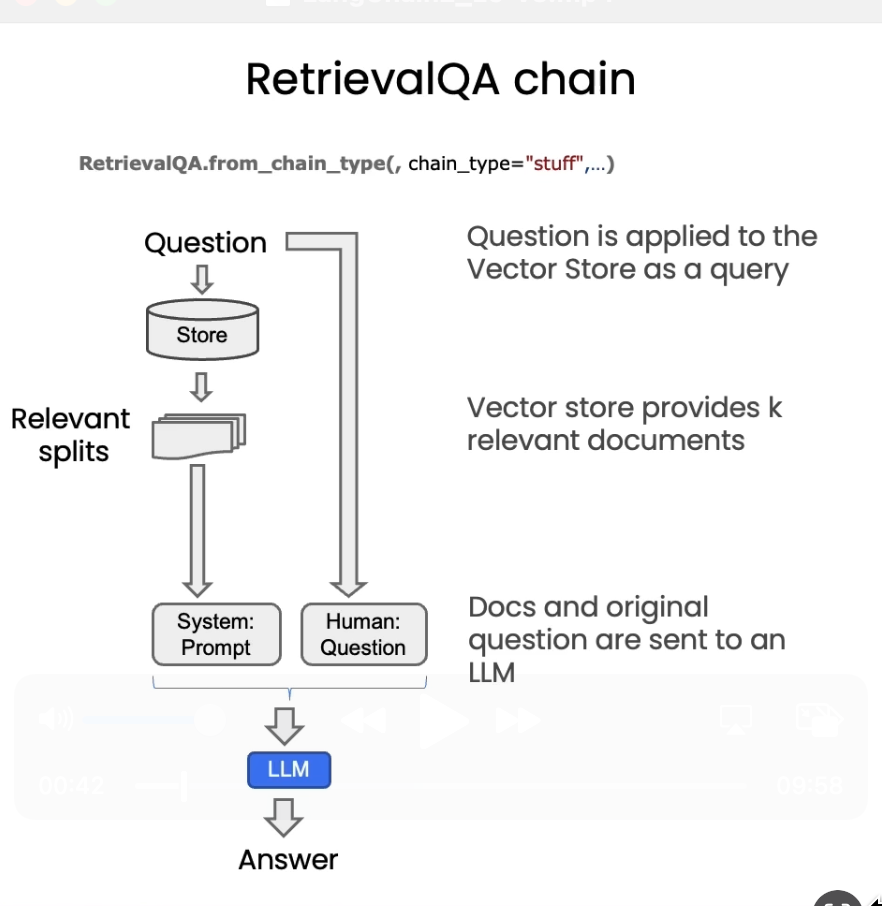

In [ ]:
from langchain.chains import RetrievalQA

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm, 
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT},
    
)

In [ ]:
# question = "What is a good cache?"

In [ ]:
# question = "What are the main differences between the three engine types available for the Chevy Colorado?"

In [ ]:
 question = "What are the minimum requirements to install redis Enterprise?"

In [ ]:
result = qa_chain({"query": question})

In [ ]:
result["result"]

In [ ]:
result["source_documents"][0]

## Add Redis Chat Memory
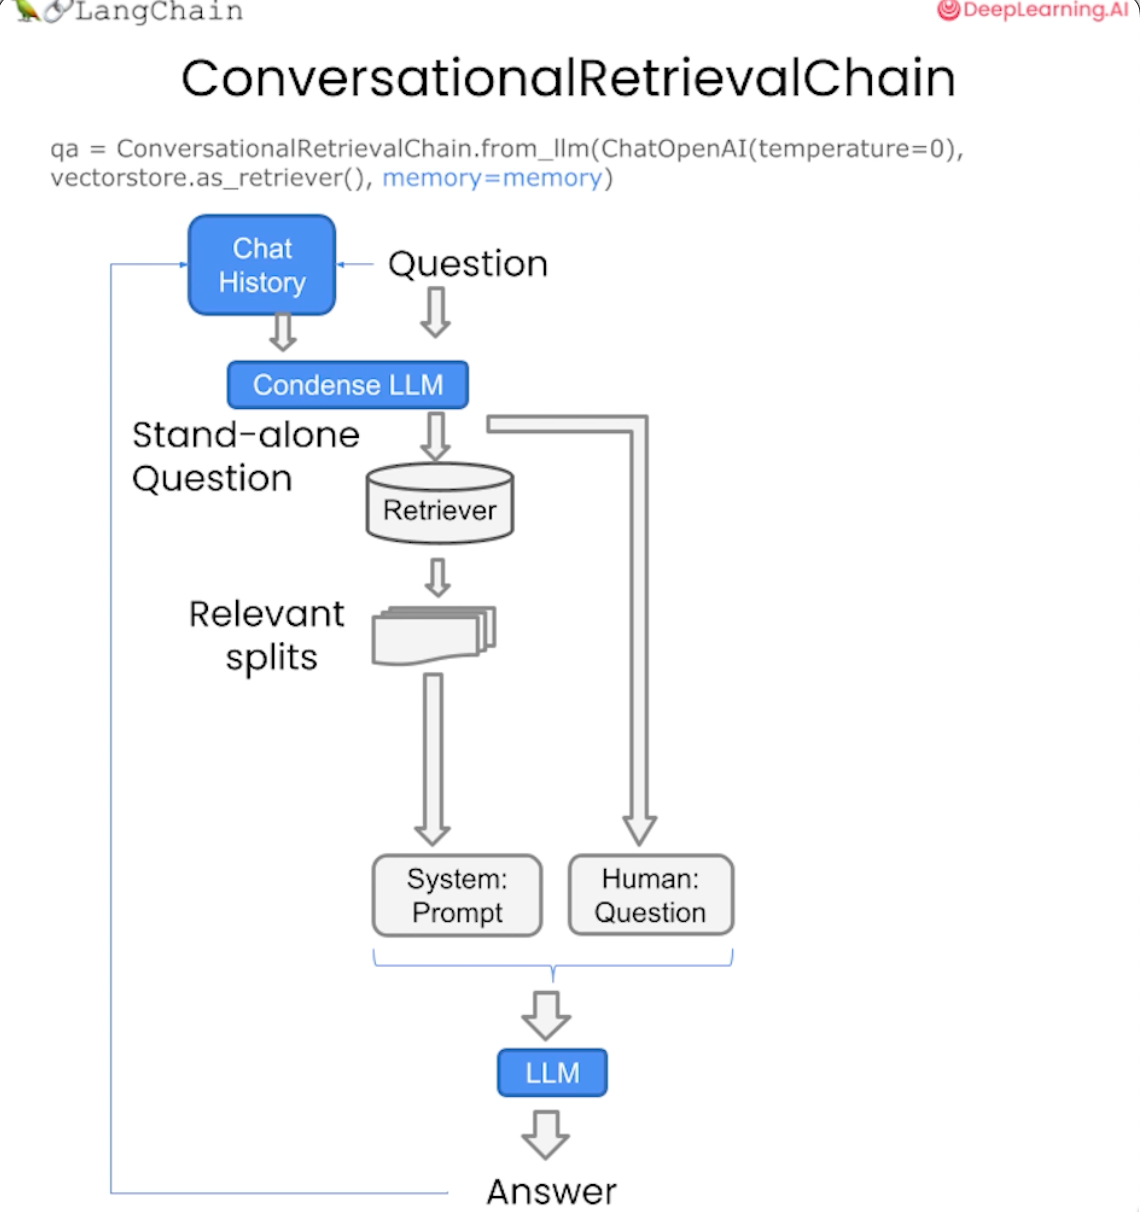

In [ ]:
from langchain.memory import ConversationBufferMemory
from langchain.memory.chat_memory import ChatMessageHistory
from langchain.memory.chat_message_histories import RedisChatMessageHistory
message_history = RedisChatMessageHistory(url=redis_url, ttl=600, session_id="session-message")

memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    chat_memory=message_history
)

In [ ]:
# see Memory not supported with sources chain?  https://github.com/langchain-ai/langchain/issues/2256
from langchain.chains import ConversationalRetrievalChain
qa = ConversationalRetrievalChain.from_llm(
    llm,
    retriever=vectordb.as_retriever(),
    #return_source_documents=True,
    # chain_type_kwargs={"prompt": QA_CHAIN_PROMPT},
    memory=memory
)

In [ ]:
question = "What are the minimum requirements to install redis Enterprise?"
result = qa({"question": question})

In [ ]:
result['answer']

In [ ]:
question = "What about production?"
result = qa({"question": question})

In [ ]:
result['answer']

In [ ]:
memory.clear()

In [ ]:
memory.chat_memory.messages

## User Interface
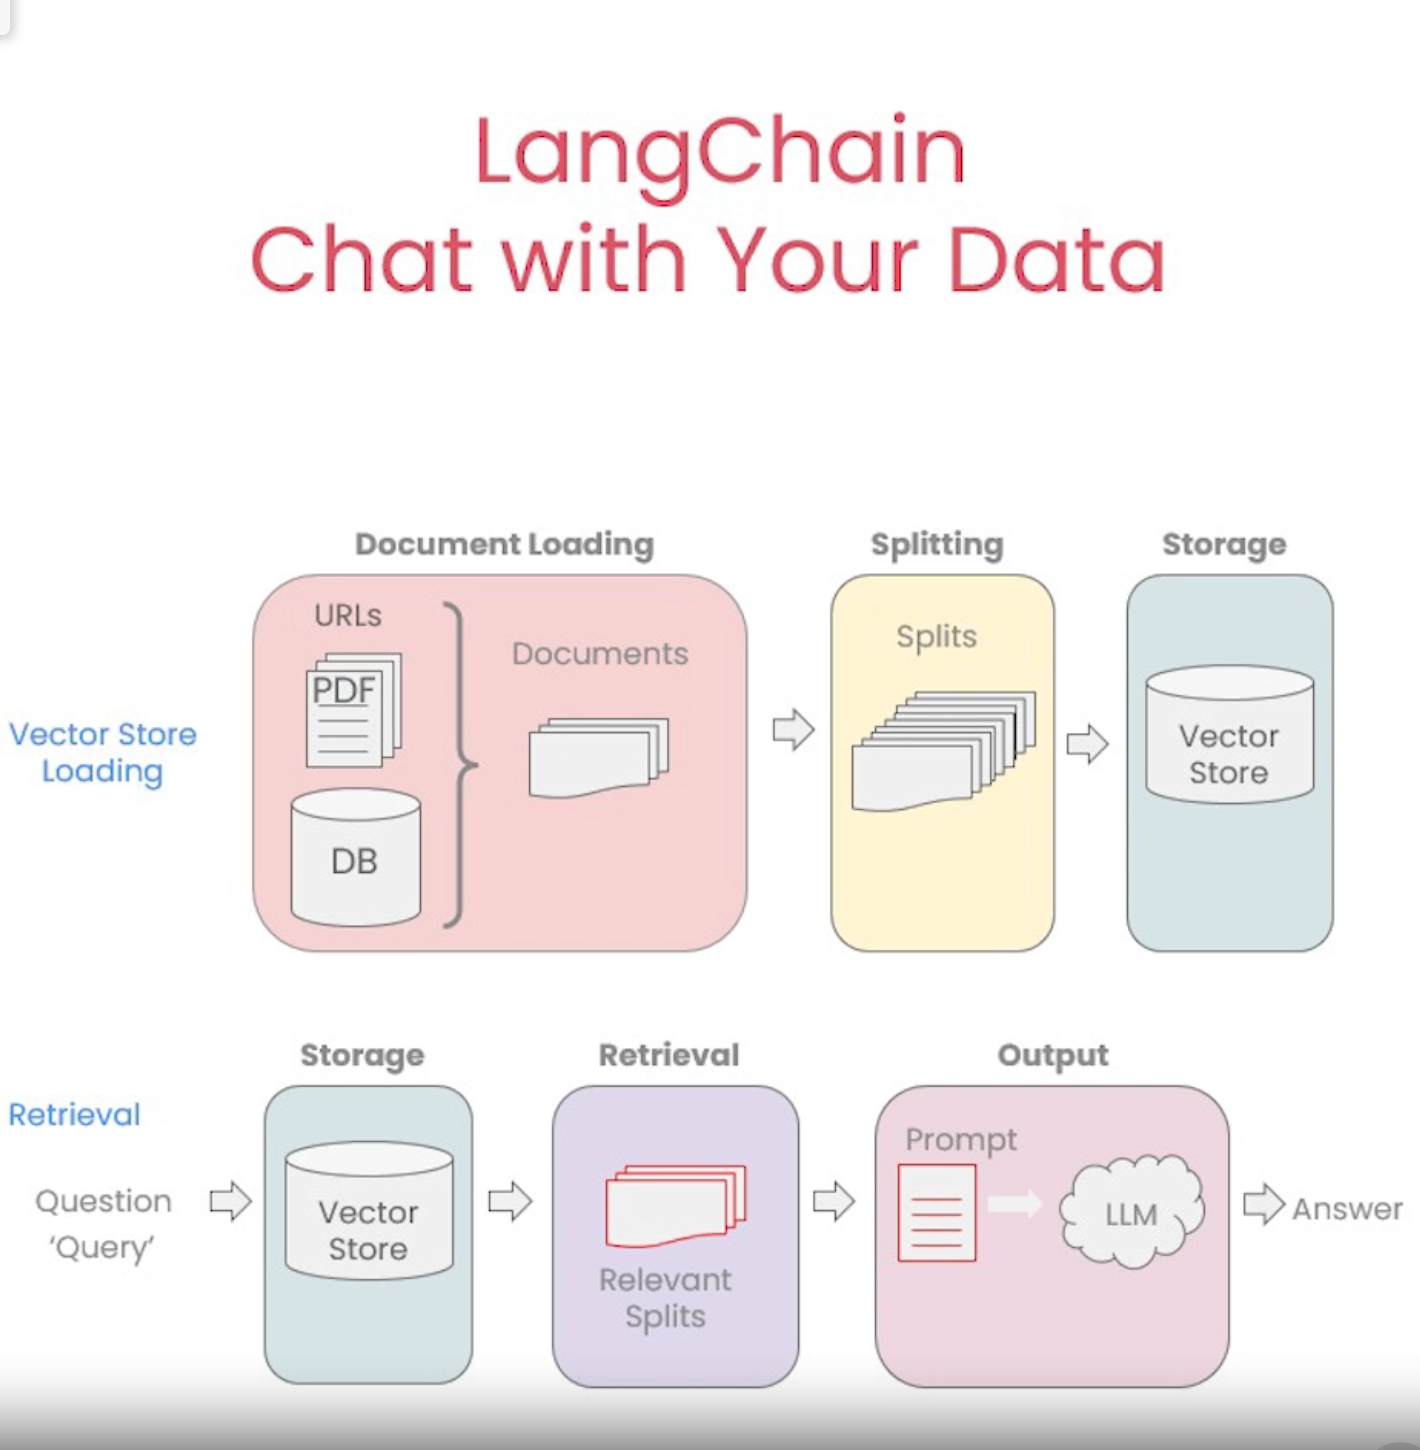

In [ ]:
! pip install gradio

In [ ]:
import gradio as gr
def respond(message, chat_history):    
    result  = qa({"question": message})
    completion = result['answer']
    chat_history.append((message, completion))
    return "", chat_history

def clearmemory():
    memory.clear()

def showMemory():
    return memory.chat_memory.messages

with gr.Blocks() as demo:
    with gr.Tab("Chat"):
        chatbot = gr.Chatbot(height=240)
        msg = gr.Textbox(label="Prompt")
        btn = gr.Button("Submit")
        clear = gr.ClearButton(components=[msg, chatbot], value="Clear console")
        btn.click(respond, inputs=[msg, chatbot], outputs=[msg, chatbot])
        msg.submit(respond, inputs=[msg, chatbot], outputs=[msg, chatbot]) #Press enter to submit
        #gr.ChatInterface(respond)
    with gr.Tab("Memory"):
        memorybox = gr.Textbox(label="Memory")
        clearMemoryBtn = gr.Button("Clear Memory")
        clearMemoryBtn.click(clearmemory)
        showMemoryBtn = gr.Button("Show Memory")
        showMemoryBtn.click(showMemory, outputs=memorybox)
    
gr.close_all()
demo.launch()